# Introduction

The goal of this project is to use a large dataset of used US car prices to predict the market value of a car. The original dataset contains 1 million rows and 66 columns, in which we will expand, get rid of, and alter many of these columns in order to create a suitable dataset for machine learning. Above all, we prioritize accuracy and a low loss function for our machine learning models when it comes to prediction. Iterpretability is not that important to us, since we can see this being a real life application that is able to evaluate cars where customers do not necessarily care why we ouput certain numbers. We will be using PCA to reduce the dimensionality of the dataset after preprocessing and feature engineering. From there we will use a few different ML models to see which performs the best. 

# Installing Dependencies and Loading the Data



In [ ]:
!pip install pyzipcode
!pip install fsspec>=0.3.3
!pip install dask_ml
!pip install dask distributed --upgrade
!pip install pyspark

Requirement already up-to-date: dask in /usr/local/lib/python3.7/dist-packages (2021.4.1)
Requirement already up-to-date: distributed in /usr/local/lib/python3.7/dist-packages (2021.4.1)
ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


In [41]:
from google.colab import drive
import multiprocessing
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import csv
from PIL import Image
import urllib.request
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# This data was obtained by running a self made crawler on Cargurus inventory in September 2020.
filepath = "/content/drive/MyDrive/CIS545/used_cars_data.csv"

# index by vin which is the unique identifier
cars = pd.read_csv(filepath, index_col='vin', nrows=1000000)
cars.head()

In [ ]:
print("Shape: {} \n".format(cars.shape))
print("Columns: \n {} \n".format(cars.columns))

# Preprocessing

There are 1 million rows of data with 66 columns. Our next goal is to explore missing data. We first check to see if a value is missing in a column because it doesn't apply to that particular instance or if it simply was not recorded. In the former case we can fill it in with a 0. In the latter case we have 2 options. We can either try to impute the data if there seems to be some sort of reasonable way to do so. If not, we will simply drop the column if too much data is missing. Imputation will be done based on a variety of factors such as categorical/numeric and intuitive/non-intuitive ways to fill in missing values. 

In [ ]:
missing = pd.DataFrame(cars.isnull().sum(), columns=['count']).sort_values(by='count', ascending=False)
missing = missing[missing['count'] != 0]
missing['Percentage'] = (missing['count']/len(cars))*100
missing

,count,Percentage
is_certified,1000000,100.0000
vehicle_damage_category,1000000,100.0000
combine_fuel_economy,1000000,100.0000
bed,993552,99.3552
cabin,980608,98.0608
is_oemcpo,947850,94.7850
is_cpo,928793,92.8793
bed_length,877361,87.7361
bed_height,877361,87.7361
owner_count,494881,49.4881


We can outright drop vehicle_damage_category, combine_fuel_economy, and is_certified because they are all missing. 

Further using the Kaggle documentation "bed_height: Type String. Almost all null values. Offers no value." We can also drop this.

Torque/Power is also entirely dependent on horspower so we can drop it as well. 

Trim name is also not useful after looking at it so we will drop it. 

Engine Cylinders is the same thing as engine type so we will drop it

trimId is not useful

interior/exterior color is repeated data

daysonmarket is calculated wrong, we will recalculate based on listing date later

city is repeated information, we will get the state information later on

long/lat not needed

model_name has too many unique values to be one hot encoded and thus would rather use make_name since it will probably carry most of the information 

In [ ]:
# First we remove main_picture_url to store for later use 
# pictures = cars['main_picture_url']

# next we keep the description in case we want to use it later
description = cars['description']

cars.drop(inplace=True, columns=['vehicle_damage_category', 'combine_fuel_economy', 'is_certified', 'is_oemcpo',
                                 'bed_height', 'bed_length', 'torque', 'power', 'trim_name', 'engine_cylinders',
                                 'main_picture_url', 'trimId', 'interior_color', 'exterior_color', 'description',
                                 'sp_name', 'sp_id', 'daysonmarket', "city", "listing_id", 'latitude', 
                                 'longitude', 'model_name', 'bed', 'cabin'])


For the rest of the features, we have to carefully check each one and decide on the course of action on an individual level. We will be imputting using KNN later with the 5 closest neighbors using the L2 distance between points. Due to its computational nature in that it computes the distances all at once, we will group all features that will be imputed with KNN at the end in order to save on runtime. 

In [ ]:
# missing bc is not certified pre-owned
cars['is_cpo'].fillna(0, inplace=True)

# missing bc does not apply
cars['theft_title'].fillna(0, inplace=True)

# missing bc is "probably" not a cab
cars['isCab'].fillna(0, inplace=True)

# not damaged
cars['frame_damaged'].fillna(False, inplace=True)

# not salvaged
cars['salvage'].fillna(False, inplace=True)

# no way to impute franchise so we leave that up the the model
cars['franchise_make'].fillna('Unknown', inplace=True)

# no other major options
cars['major_options'].fillna('None', inplace=True)

# no wheel_system_display
cars['wheel_system_display'].fillna('None', inplace=True)

In [ ]:
# impute based on mode for the categorical data 
# these features arent imputed with a machine learning model because
# wasting time/effort imputing them would lead to worst results and there is
# no reasonable way to impute them besides the mean 

cars['wheel_system'].fillna(cars['wheel_system'].mode().iloc[0], inplace=True)

cars['engine_type'].fillna(cars['engine_type'].mode().iloc[0], inplace=True)

cars['fuel_type'].fillna(cars['fuel_type'].mode().iloc[0], inplace=True)

cars['transmission_display'].fillna(cars['transmission_display'].mode().iloc[0], inplace=True)

cars['transmission'].fillna(cars['transmission'].mode().iloc[0], inplace=True)

cars['body_type'].fillna(cars['body_type'].mode().iloc[0], inplace=True)

Next we go through and make sure that the input is both properly formatted (i.e what we expect it to be) and we make the proper type conversions

In [ ]:
def type_convert(x):
  if type(x) == float:
    return x
  elif x == '--':
    return float('NaN')
  else:
    return float(x.split(" ")[0])

In [ ]:
# essentially gets rid of the label after the float
labels = ['back_legroom', 'front_legroom', 'fuel_tank_volume', 'height', 'length', 'maximum_seating', 'width', 'wheelbase'] 

for label in labels:
  cars[label] = cars[label].apply(lambda x: type_convert(x))

In [ ]:
missing = pd.DataFrame(cars.isnull().sum(), columns=['count']).sort_values(by='count', ascending=False)
missing = missing[missing['count'] != 0]

For the rest of the columns, we will impute their values using Iterative Value Imputer. We choose this metric because it is a reliable, yet simple way to impute missing values. 
However, it is slow, especially for such a large dataset, so we only do it once and then save the new dataframe so we never have to do it again. The values imputed have either a very low percentage of data missing, or are can be easily predicted by similar entries. 

In [ ]:
imputer = IterativeImputer(max_iter=100, random_state=0, skip_complete=True, add_indicator=True, verbose=2)
cars_imputed = imputer.fit_transform(cars[missing.index])

[IterativeImputer] Completing matrix with shape (1000000, 17)
[IterativeImputer] Ending imputation round 1/100, elapsed time 18.57
[IterativeImputer] Change: 261951.15423639075, scaled tolerance: 4290.461 
[IterativeImputer] Ending imputation round 2/100, elapsed time 36.51
[IterativeImputer] Change: 181801.9366219432, scaled tolerance: 4290.461 
[IterativeImputer] Ending imputation round 3/100, elapsed time 54.51
[IterativeImputer] Change: 19152.380857362557, scaled tolerance: 4290.461 
[IterativeImputer] Ending imputation round 4/100, elapsed time 72.17
[IterativeImputer] Change: 10343.974709911496, scaled tolerance: 4290.461 
[IterativeImputer] Ending imputation round 5/100, elapsed time 90.29
[IterativeImputer] Change: 8067.921609584963, scaled tolerance: 4290.461 
[IterativeImputer] Ending imputation round 6/100, elapsed time 108.28
[IterativeImputer] Change: 6088.484534970106, scaled tolerance: 4290.461 
[IterativeImputer] Ending imputation round 7/100, elapsed time 126.45
[Itera

In [ ]:
cols = list(missing.index)
imputed = []

for col in cols:
  name = col + "_imputed"
  imputed.append(name)

cols = cols + imputed
cars_imputed = pd.DataFrame(cars_imputed, columns=cols)

In [ ]:
index = pd.DataFrame(cars.index, columns=['vin'])
cars_imputed = pd.concat([index, cars_imputed], axis=1)

In [ ]:
cars = cars.merge(cars_imputed, how='inner', on='vin', suffixes=('_drop', ''))

#Drop the duplicate columns
cars.drop([col for col in cars.columns if 'drop' in col], axis=1, inplace=True)

We now save the processed dataframe so we do not have to repeat the above code

In [ ]:
cars.head()

,vin,body_type,dealer_zip,engine_type,frame_damaged,franchise_dealer,franchise_make,fuel_type,isCab,is_cpo,is_new,listed_date,listing_color,major_options,make_name,price,salvage,savings_amount,theft_title,transmission,transmission_display,wheel_system,wheel_system_display,year,owner_count,fleet,has_accidents,highway_fuel_economy,city_fuel_economy,back_legroom,front_legroom,engine_displacement,horsepower,mileage,fuel_tank_volume,maximum_seating,width,height,wheelbase,length,seller_rating,owner_count_imputed,fleet_imputed,has_accidents_imputed,highway_fuel_economy_imputed,city_fuel_economy_imputed,back_legroom_imputed,front_legroom_imputed,engine_displacement_imputed,horsepower_imputed,mileage_imputed,fuel_tank_volume_imputed,maximum_seating_imputed,width_imputed,height_imputed,wheelbase_imputed,length_imputed,seller_rating_imputed
0,ZACNJABB5KPJ92081,SUV / Crossover,960,I4,False,True,Jeep,Gasoline,0,0,True,2019-04-06,YELLOW,['Quick Order Package'],Jeep,23141.0,False,0,0,A,9-Speed Automatic Overdrive,FWD,Front-Wheel Drive,2019,0.878954,0.140410,0.097480,30.044945,25.090664,35.1,41.2,1300.0,177.0,7.000000,12.7,5.0,79.6,66.5,101.2,166.6,2.800000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SALCJ2FX1LH858117,SUV / Crossover,922,I4,False,True,Land Rover,Gasoline,0,0,True,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,46500.0,False,0,0,A,9-Speed Automatic Overdrive,AWD,All-Wheel Drive,2020,0.834316,0.203876,0.091933,26.853845,20.033274,38.1,39.1,2000.0,246.0,8.000000,17.7,7.0,85.6,68.0,107.9,181.0,3.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JF1VA2M67G9829723,Sedan,969,H4,False,True,FIAT,Gasoline,False,0,False,2017-04-25,UNKNOWN,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Subaru,46995.0,False,0,False,M,6-Speed Manual,AWD,All-Wheel Drive,2016,3.000000,0.000000,0.000000,23.000000,17.000000,35.4,43.3,2500.0,305.0,82413.717601,15.9,5.0,78.9,58.1,104.3,180.9,4.370081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,SALRR2RV0L2433391,SUV / Crossover,922,V6,False,True,Land Rover,Gasoline,0,0,True,2020-02-26,GRAY,None,Land Rover,67430.0,False,0,0,A,8-Speed Automatic Overdrive,AWD,All-Wheel Drive,2020,0.842779,0.167573,0.083460,20.073504,13.057028,37.6,39.0,3000.0,340.0,11.000000,23.5,7.0,87.4,73.0,115.0,195.1,3.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SALCJ2FXXLH862327,SUV / Crossover,922,I4,False,True,Land Rover,Gasoline,0,0,True,2020-04-25,BLACK,['Adaptive Cruise Control'],Land Rover,48880.0,False,0,0,A,9-Speed Automatic Overdrive,AWD,All-Wheel Drive,2020,0.834307,0.203876,0.091932,26.853859,20.033288,38.1,39.1,2000.0,246.0,7.000000,17.7,7.0,85.6,68.0,107.9,181.0,3.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cars.to_csv('/content/drive/MyDrive/CIS545/used_cars_clean.csv')

With that, we finally have our cleaned and preprocessed dataframe that we can begin working on. Next up is EDA.

# Exploratory Data Analysis

The main purpose of EDA is to get a better understanding of the dataset we are working with. We want to understand each of the features, whats important and what isn't important, any correlation between any of the features. We visualize different parts of the data to get a better understanding of it and make it easier for us to discover patterns. 

In [ ]:
filepath = '/content/drive/MyDrive/CIS545/used_cars_clean.csv'

# index by vin which is the unique identifier
cars = pd.read_csv(filepath, index_col='vin', nrows=1000000)
cars.drop(inplace=True, columns='Unnamed: 0')
cars.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



,body_type,dealer_zip,engine_type,frame_damaged,franchise_dealer,franchise_make,fuel_type,isCab,is_cpo,is_new,listed_date,listing_color,major_options,make_name,price,salvage,savings_amount,theft_title,transmission,transmission_display,wheel_system,wheel_system_display,year,owner_count,fleet,has_accidents,highway_fuel_economy,city_fuel_economy,back_legroom,front_legroom,engine_displacement,horsepower,mileage,fuel_tank_volume,maximum_seating,width,height,wheelbase,length,seller_rating,owner_count_imputed,fleet_imputed,has_accidents_imputed,highway_fuel_economy_imputed,city_fuel_economy_imputed,back_legroom_imputed,front_legroom_imputed,engine_displacement_imputed,horsepower_imputed,mileage_imputed,fuel_tank_volume_imputed,maximum_seating_imputed,width_imputed,height_imputed,wheelbase_imputed,length_imputed,seller_rating_imputed
vin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZACNJABB5KPJ92081,SUV / Crossover,960,I4,False,True,Jeep,Gasoline,0,0,True,2019-04-06,YELLOW,['Quick Order Package'],Jeep,23141.0,False,0,0,A,9-Speed Automatic Overdrive,FWD,Front-Wheel Drive,2019,0.878954,0.140410,0.097480,30.044945,25.090664,35.1,41.2,1300.0,177.0,7.000000,12.7,5.0,79.6,66.5,101.2,166.6,2.800000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SALCJ2FX1LH858117,SUV / Crossover,922,I4,False,True,Land Rover,Gasoline,0,0,True,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,46500.0,False,0,0,A,9-Speed Automatic Overdrive,AWD,All-Wheel Drive,2020,0.834316,0.203876,0.091933,26.853845,20.033274,38.1,39.1,2000.0,246.0,8.000000,17.7,7.0,85.6,68.0,107.9,181.0,3.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JF1VA2M67G9829723,Sedan,969,H4,False,True,FIAT,Gasoline,False,0,False,2017-04-25,UNKNOWN,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Subaru,46995.0,False,0,False,M,6-Speed Manual,AWD,All-Wheel Drive,2016,3.000000,0.000000,0.000000,23.000000,17.000000,35.4,43.3,2500.0,305.0,82413.717601,15.9,5.0,78.9,58.1,104.3,180.9,4.370081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
SALRR2RV0L2433391,SUV / Crossover,922,V6,False,True,Land Rover,Gasoline,0,0,True,2020-02-26,GRAY,None,Land Rover,67430.0,False,0,0,A,8-Speed Automatic Overdrive,AWD,All-Wheel Drive,2020,0.842779,0.167573,0.083460,20.073504,13.057028,37.6,39.0,3000.0,340.0,11.000000,23.5,7.0,87.4,73.0,115.0,195.1,3.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SALCJ2FXXLH862327,SUV / Crossover,922,I4,False,True,Land Rover,Gasoline,0,0,True,2020-04-25,BLACK,['Adaptive Cruise Control'],Land Rover,48880.0,False,0,0,A,9-Speed Automatic Overdrive,AWD,All-Wheel Drive,2020,0.834307,0.203876,0.091932,26.853859,20.033288,38.1,39.1,2000.0,246.0,7.000000,17.7,7.0,85.6,68.0,107.9,181.0,3.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 1440x720 with 0 Axes>

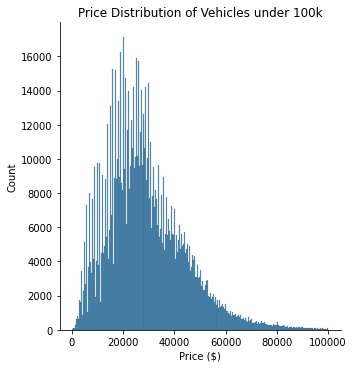

In [ ]:
# vast majority of cars are under 100k so thats what we limit it to or else the plot looks weird
plt.figure(figsize=(20,10))
sns.displot(cars[cars['price'] < 100000], x='price')
plt.xlabel('Price ($)')
plt.title('Price Distribution of Vehicles under 100k')
plt.show()



*   Price distribution of cars is definitely right skewed which tells us that the prediction class is going to be unbalanced in that we are going to have more training examples of around 0-40k range. 
*   The data does seem to be unimodal with a peak around 21k ish.





<Figure size 2160x2160 with 0 Axes>

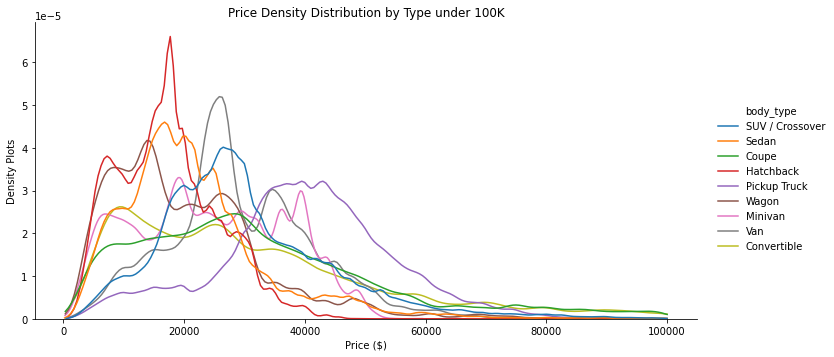

In [ ]:
plt.figure(figsize=(30,30))
sns.displot(cars[cars['price'] < 100000], x='price', hue='body_type', kind='kde', bw_adjust=0.6, cut=0, common_norm=False, height=5, aspect=2)
plt.xlabel('Price ($)')
plt.ylabel('Density Plots')
plt.title('Price Density Distribution by Type under 100K')
plt.show()

Insight:


*   Pickup Trucks, on average, are more expensive than other types 
*   Hatchbacks/Sedans are less expensive than other types 
*   All density plots seem to be very right skewed 



In [ ]:
cars[['price', 'wheel_system']].groupby('wheel_system').median()

,price
wheel_system,
4WD,36788.0
4X2,29958.0
AWD,28900.0
FWD,19390.0
RWD,27925.0


<Figure size 2160x2160 with 0 Axes>

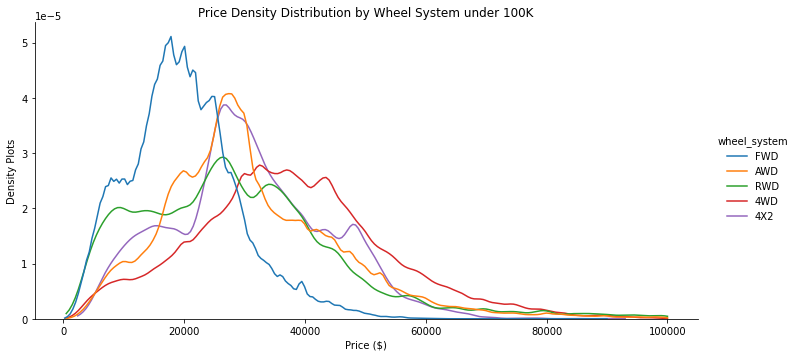

In [ ]:
plt.figure(figsize=(30,30))
sns.displot(cars[cars['price'] < 100000], x='price', hue='wheel_system', kind='kde', bw_adjust=0.6, cut=0, common_norm=False, height=5, aspect=2)
plt.xlabel('Price ($)')
plt.ylabel('Density Plots')
plt.title('Price Density Distribution by Wheel System under 100K')
plt.show()

Ordering of the price of cars based on wheel system, on average (using median), in descending order

  * 4WD(36.7k)
  * 4x2 (30K)
  * AWD (28.9k)
  * RWD (28k)
  * FWD (19.3k) 

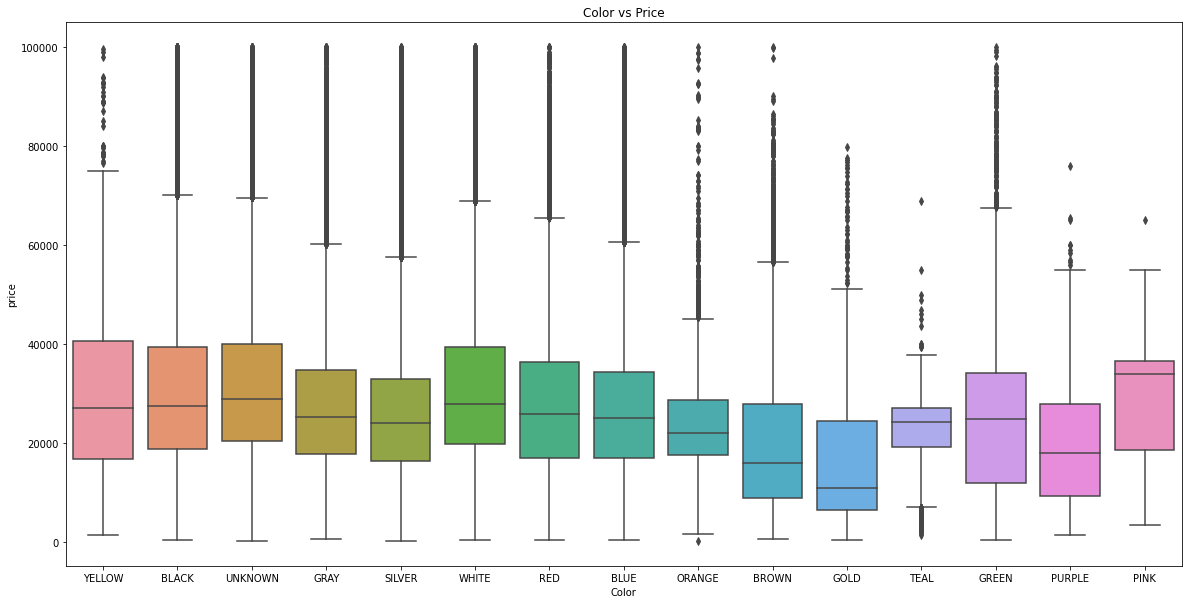

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x='listing_color', y='price', data=cars[cars['price'] < 100000])
plt.xlabel('Color')
plt.title("Color vs Price")
plt.show()

Car color does not seem to influence price very much according the the mean. The data is definitely right skewed though, for a lot of these plots, which does give us a hint that we might have to use log transformation for price later on in the feature engineering section. 

In [ ]:
cars[['price', 'owner_count']][cars['owner_count_imputed'] == 0].groupby('owner_count').mean()


,price
owner_count,
1.0,24594.152897
2.0,17123.860872
3.0,13718.322862
4.0,12401.670632
5.0,12092.136228
6.0,12431.499636
7.0,16153.148077
8.0,13537.602041
9.0,29959.037975


<Figure size 2160x2160 with 0 Axes>

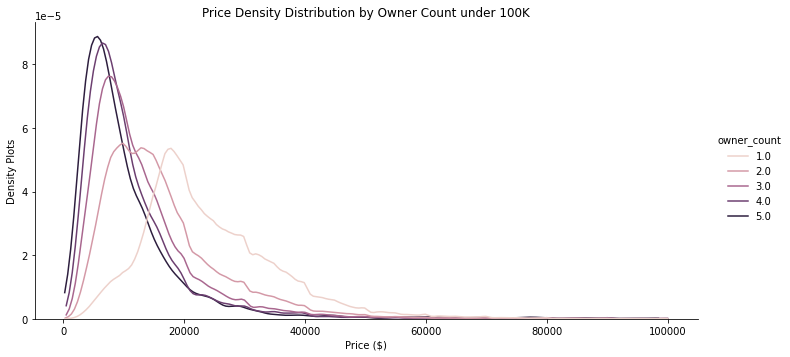

<Figure size 2160x2160 with 0 Axes>

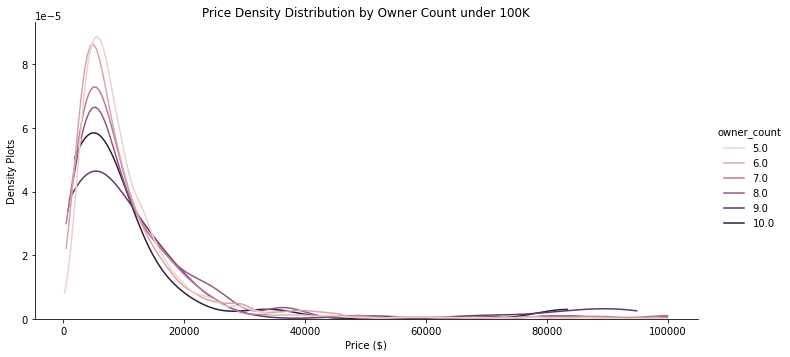

In [ ]:
for i in range(1, 3):
  plt.figure(figsize=(30,30))
  owners = cars[cars['price'] < 100000]
  owners = owners[owners['owner_count_imputed'] == 0]
  owners = owners[owners['owner_count'] <= (5*i)]
  owners = owners[owners['owner_count'] >= (5*i - 5)]
  sns.displot(owners, x='price', hue='owner_count', kind='kde', bw_adjust=0.6, cut=0, common_norm=False, height=5, aspect=2)
  plt.xlabel('Price ($)')
  plt.ylabel('Density Plots')
  plt.title('Price Density Distribution by Owner Count under 100K')
  plt.show()

There are slight differences in price in cars with 1-5 owners. However, anything past 5 owners does not have any meaningful difference in price. 

Cars with 1 owner, on average, are worth about 7000 more than cars with 2 owners.

Cars with 2 owners, on average, are worth about 3000 more than cars with 3 owners.

Cars with 3-5 owners differ only by about 1000 each time.

What we can get from this is that the biggest difference in car ownership is between 1 and 2 and 2 and 3, and after that it is not really meaningful. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 <a list of 80 Text major ticklabel objects>)

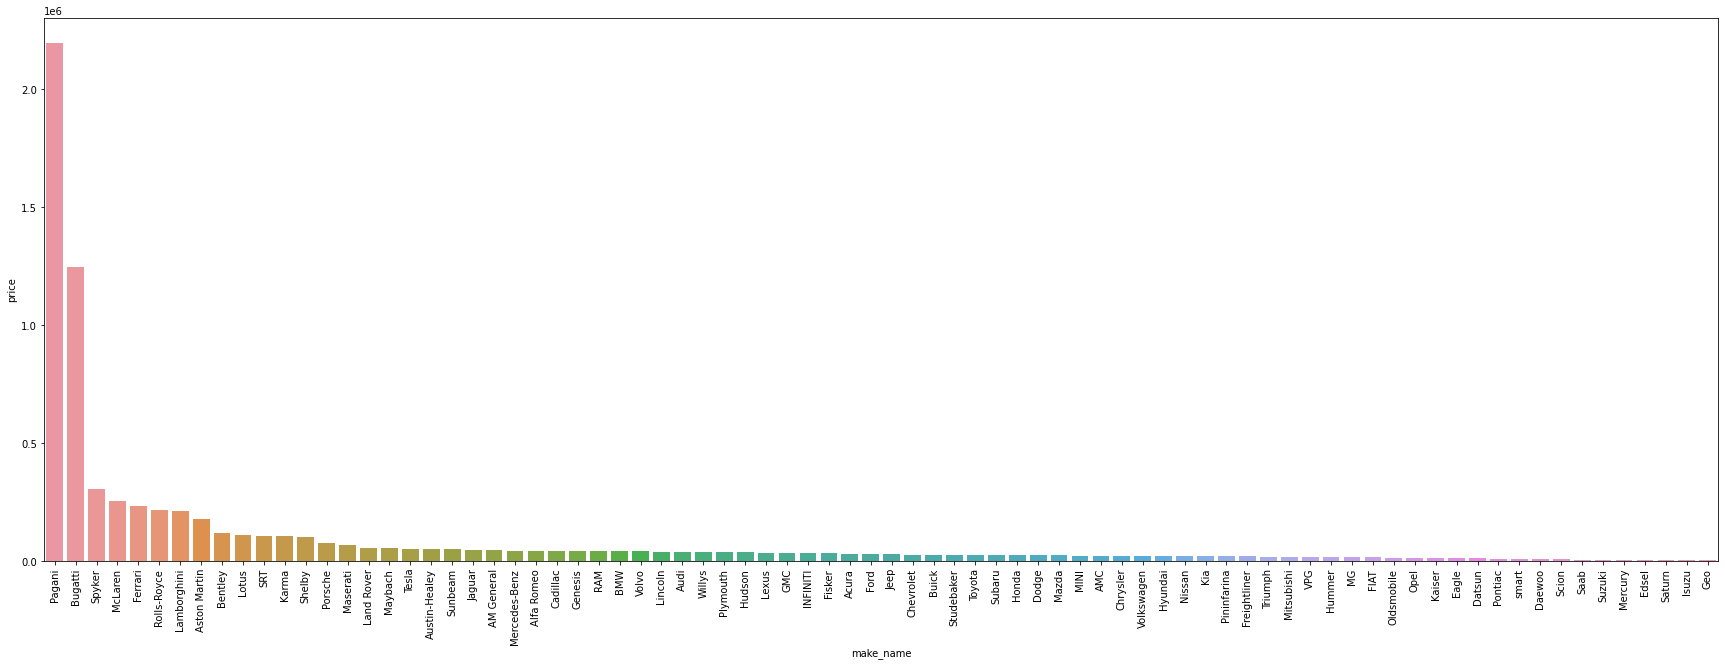

In [ ]:
price_mean = cars[['price','make_name']].groupby('make_name').mean().sort_values(by='price', ascending=False)

plt.figure(figsize=(30,10))
sns.barplot(x=price_mean.index, y="price", data=price_mean)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77]),
 <a list of 78 Text major ticklabel objects>)

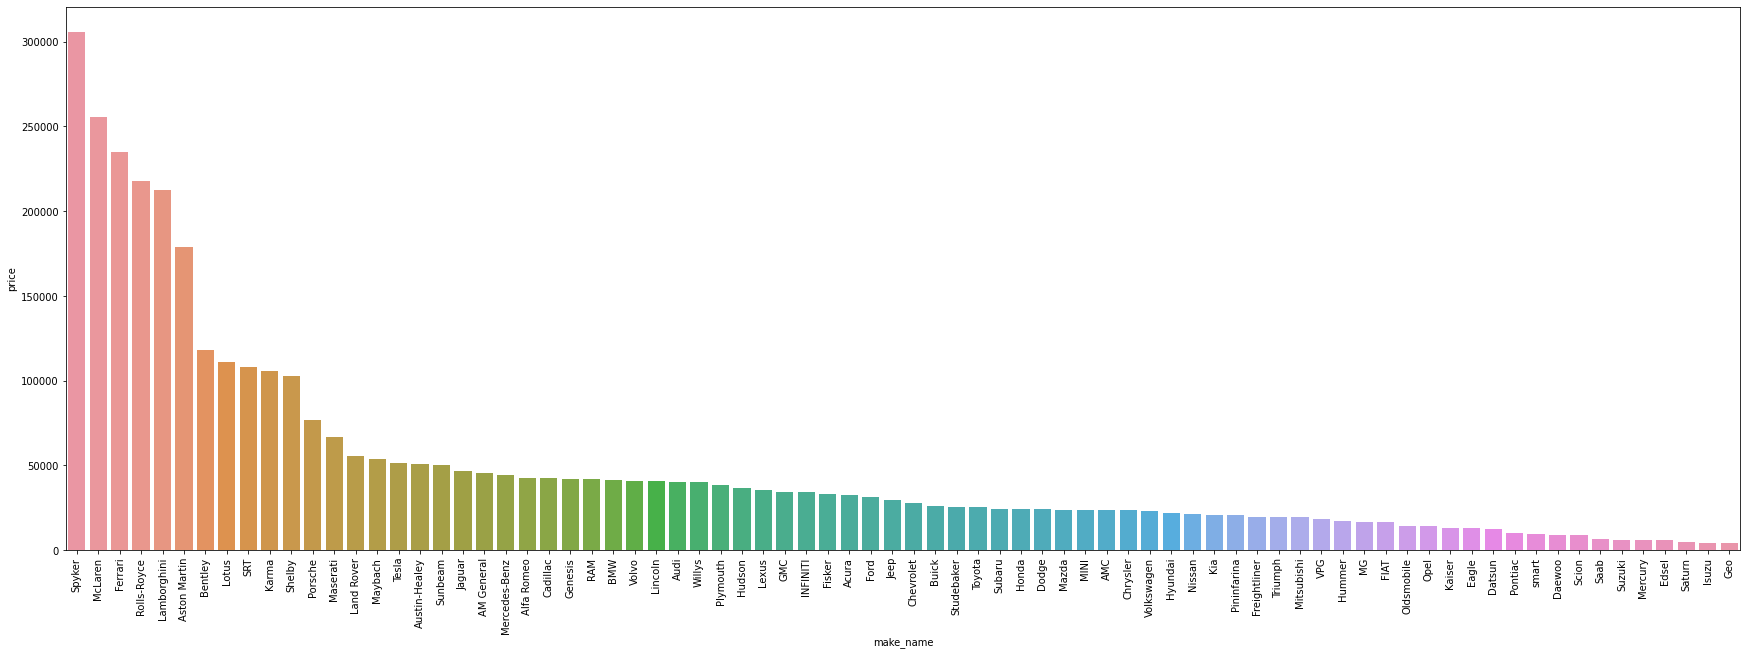

In [ ]:
price_mean = price_mean[price_mean['price'] < 1000000]

plt.figure(figsize=(30,10))
sns.barplot(x=price_mean.index, y="price", data=price_mean)
plt.xticks(rotation=90)

As expected, the luxury cars dominate the barplot of prices by manufactor. If, however, we remove all luxury cars and look at 90% of the market by limiting our data to everything below 100k we might be able to get more insight.

Text(0.5, 1.0, '2d KDE plot Price vs Year')

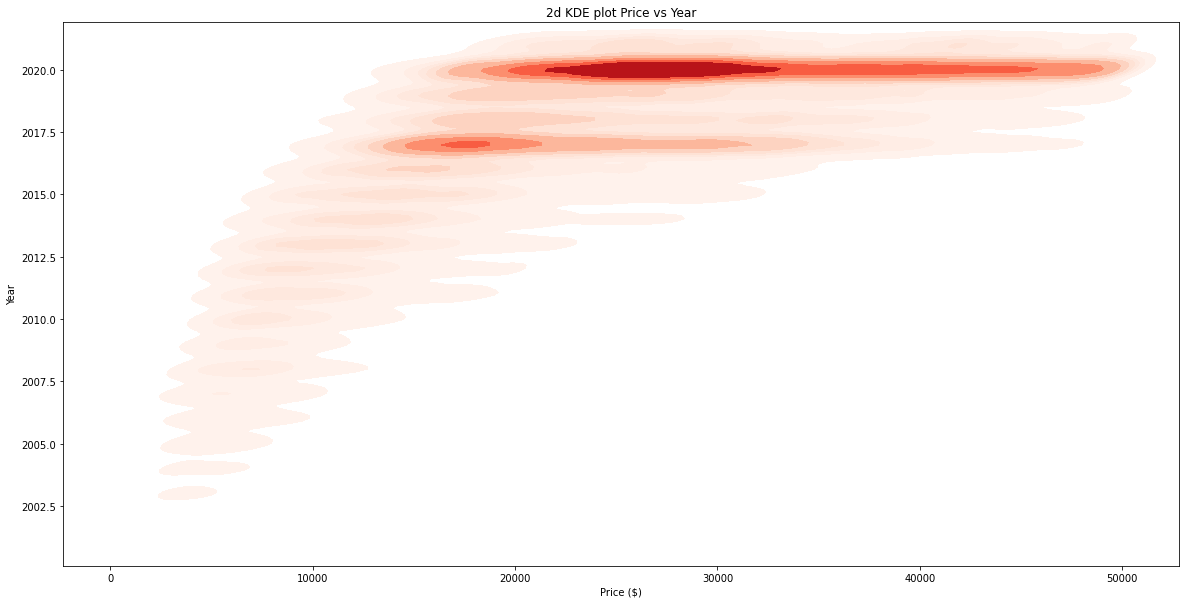

In [ ]:
smpl = cars.sample(frac=0.05, random_state=1)
plt.figure(figsize=(20,10))
smpl = smpl[smpl['price'] < 50000]
smpl = smpl[smpl['year'] > 2000]
sns.kdeplot(x=smpl.price, y=smpl.year, cmap="Reds", bw_adjust=.5, shade=True)
plt.xlabel('Price ($)')
plt.ylabel('Year')
plt.title('2d KDE plot Price vs Year')

The amount of cars with years below 2000 is negligble and thus we limit our visualization to all cars above 1990 with price below 50k. With this limitation it seems that there is a strong positive correlation between price and year (which is to be expected). The maximum density occurs between the price of around 20k-30k with year 2020. 

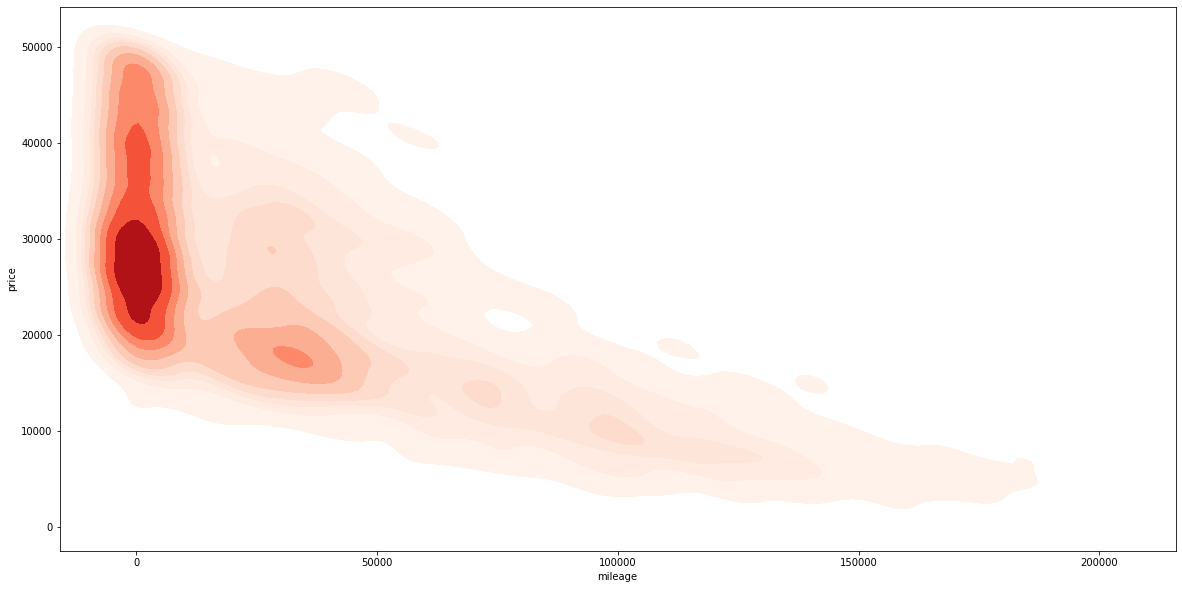

In [ ]:
plt.figure(figsize=(20,10))
dta = cars[cars['mileage'] < 200000]
dta = dta[dta['mileage_imputed'] == 0]
dta = dta[dta['price'] < 100000]
dta = dta.sample(frac=0.1, random_state=1)

sns.kdeplot(x=dta.mileage, y=smpl.price, cmap="Reds", bw_adjust=.5, shade=True)

There seems to be a strong negative correlation with price and mileage. I.e a higher mileage means a lower price 

# Feature Engineering

Goals:
  * Log Transformation - fix skew
  * Feature augmentation - get information from useful features
  * Scaling - ensure data is on same scale for scale variant algorithms such as linear regression 
  * One Hot Encoding - turn categorical features to numeric 

In [ ]:
import dask.dataframe as dd

filepath = '/content/drive/MyDrive/CIS545/used_cars_clean.csv'
cars = pd.read_csv(filepath, index_col='vin')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
from pyzipcode import ZipCodeDatabase

def get_state(x):
  zcdb = ZipCodeDatabase()
  try:
    loc = zcdb[x]
    return loc.state
  except:
    return 0
 
# convert zip codes to state to bin data better but retain same information 
cars['dealer_zip'] = cars['dealer_zip'].apply(lambda x: get_state(x))
cars.rename(columns={"dealer_zip": "State"}, inplace=True)

In [ ]:
cars.to_csv('/content/drive/MyDrive/CIS545/used_cars_clean.csv')

We want to decrease the number of unique values in major_options, because a lot of information is repeated. We will create individual columns for each feature in the major options for the dataframe. This will only add 133 new columns instead of the 119333 columns we would have made previously. 

We first parse all of the available options, by splitting the string, getting rid of any non alphabetical characters, and stripping any preceding whitespace. 
We then expand our cars dataframe by adding a one hot column for each feature in which there is a 1 if the car has that feature and a 0 otherwise. 

In [ ]:
filepath = '/content/drive/MyDrive/CIS545/used_cars_clean.csv'
cars = pd.read_csv(filepath, index_col='vin')

In [ ]:
import re

options = set()
regex = re.compile('[^a-zA-Z ]')

# gets a set of all perks
for option in cars['major_options'].unique():
  option = option.lower()
  for perk in option.split(','):
    perk = regex.sub('', perk)
    options.add(perk.lstrip())

In [ ]:
# creates new columns 
for option in options:
  cars[option] = np.where(cars['major_options'].str.lower().str.find(option) != -1, 1, 0)

# we can now drop major options after getting all the information 
cars.drop(inplace=True, columns=['major_options'])

In [ ]:
cars.to_csv('/content/drive/MyDrive/CIS545/used_cars_clean2.csv')

We will now calculate how long the car has been on the market for

In [ ]:
filepath = '/content/drive/MyDrive/CIS545/used_cars_clean2.csv'
cars = pd.read_csv(filepath, index_col='vin')

In [ ]:
import datetime

# now we convert listed_date to a datetime object 
cars['listed_date'] = pd.to_datetime(cars['listed_date'], format = '%Y-%m-%d')

def get_days_past(x):
  now = datetime.datetime.now()
  diff = now - x
  seconds = diff.total_seconds()
  convert = 60 * 60 * 24
  days = seconds / convert
  return days 

cars['listed_date'] = cars['listed_date'].apply(lambda x: get_days_past(x))
cars.rename(columns={"listed_date": "days on market"}, inplace=True)

We will now generate a better imputation of a cars mileage if it was unknown which is signified by a mileage_imputed == 1 feature column.

In [ ]:
def mileage_impute(x):
  #average miles driven by americans per year
  avg = 14300 
  if x['mileage_imputed'] == 1:
    x['mileage'] = avg * (2021 - x['year'])
  return x

cars = cars.apply(lambda x: mileage_impute(x), axis=1)

In [ ]:
# since this data is heavily right skewed and we want it to be normally approximated
cars['price'] = np.log(cars['price'])

In [ ]:
cars.to_csv('/content/drive/MyDrive/CIS545/used_cars_clean3.csv')

We will now use Dask to standardize and one hot encode the data since using standard pandas leads to computational shortages. 

In [ ]:
import dask.dataframe as dd

filepath = '/content/drive/MyDrive/CIS545/used_cars_clean3.csv'
cars = dd.read_csv(filepath).set_index('vin')

In [ ]:
from dask_ml.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

scaler = StandardScaler(copy=False)

num_cols = list(cars.select_dtypes('number').columns)
cars[num_cols] = scaler.fit_transform(cars[num_cols])

In [ ]:
import pandas as pd

cat = list(cars.select_dtypes(exclude=["number"]).columns)

for col in cat:
  cars[col] = cars[col].astype('category')

enc = OneHotEncoder()
cars[cat] = cars[cat].categorize()
onehot = enc.fit_transform(cars[cat])


In [ ]:
# drop categorical columns
cars = cars.drop(columns=cat)

# merge cars with new one hot columns on vin index 
df = cars.merge(onehot, left_index=True, right_index=True)

# get past lazy evaluation
df.head()

,Unnamed: 0,days on market,price,savings_amount,year,owner_count,fleet,has_accidents,highway_fuel_economy,city_fuel_economy,back_legroom,front_legroom,engine_displacement,horsepower,mileage,fuel_tank_volume,maximum_seating,width,height,wheelbase,length,seller_rating,owner_count_imputed,fleet_imputed,has_accidents_imputed,highway_fuel_economy_imputed,city_fuel_economy_imputed,back_legroom_imputed,front_legroom_imputed,engine_displacement_imputed,horsepower_imputed,mileage_imputed,fuel_tank_volume_imputed,maximum_seating_imputed,width_imputed,height_imputed,wheelbase_imputed,length_imputed,seller_rating_imputed,ground effects package,...,transmission_display_5-Speed Manual Overdrive,transmission_display_6-Speed Automatic,transmission_display_6-Speed Automatic Overdrive,transmission_display_6-Speed Dual Clutch,transmission_display_6-Speed Manual,transmission_display_6-Speed Manual Overdrive,transmission_display_7-Speed Automatic,transmission_display_8-Speed Automatic,transmission_display_8-Speed Automatic Overdrive,transmission_display_8-Speed Dual Clutch,transmission_display_9-Speed Automatic,transmission_display_9-Speed Automatic Overdrive,transmission_display_Automatic,transmission_display_Continuously Variable Transmission,transmission_display_Manual,transmission_display_10-Speed Automatic,transmission_display_7-Speed Dual Clutch,transmission_display_4-Speed CVT,transmission_display_7-Speed Manual,transmission_display_7-Speed Automatic Overdrive,transmission_display_7-Speed CVT,transmission_display_6-Speed CVT,transmission_display_8-Speed Manual,transmission_display_8-Speed CVT,transmission_display_1-Speed Dual Clutch,transmission_display_10-Speed CVT,transmission_display_4-Speed Dual Clutch,transmission_display_5-Speed Dual Clutch,transmission_display_7-Speed Manual Overdrive,wheel_system_4WD,wheel_system_4X2,wheel_system_AWD,wheel_system_FWD,wheel_system_RWD,wheel_system_display_4X2,wheel_system_display_All-Wheel Drive,wheel_system_display_Four-Wheel Drive,wheel_system_display_Front-Wheel Drive,wheel_system_display_None,wheel_system_display_Rear-Wheel Drive
vin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.921144,23.941581,-0.067000,-0.51335,-13.810287,-0.129360,-0.55475,-0.419195,-0.032265,-0.003169,0.006679,-0.007707,-0.010426,0.061553,18.600474,0.012835,-0.064689,0.065792,0.032786,0.012699,-0.004357,1.436765,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,4.330213,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870317,-1.366971,2.466289,1.932629,-0.51335,-11.891662,-0.297735,-0.55475,-0.419195,-0.006567,0.028938,0.061094,-0.002447,-0.037426,0.065433,-0.335747,-0.006724,-0.067567,0.079702,0.056501,0.024829,0.000687,0.710643,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,-0.230936,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870719,0.674975,0.107365,1.587727,-0.51335,-11.891662,-0.139066,-0.55475,-0.419195,-0.020552,0.007428,0.018727,-0.007741,-0.011149,0.037371,-0.075465,0.006935,-0.061319,0.035754,0.037503,0.015541,-0.001581,0.354701,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,-0.230936,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870842,-1.670468,1.205172,2.392290,-0.51335,-11.891662,-0.136389,-0.55475,-0.419195,-0.029342,-0.000342,0.010976,-0.007641,-0.011063,0.056441,16.071

In [ ]:
# export final cleaned, preprocessed, feature engineered dataset for ML 
filepath = '/content/drive/MyDrive/CIS545/used_cars_Final.csv'
df.to_csv(filepath, single_file = True)

['/content/drive/MyDrive/CIS545/used_cars_Final.csv']

# Modeling

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import csv

We start by loading the dataset. For our initial models, we only use 100,000 rows of data due to computational and time issues.

In [ ]:
filepath = '/content/drive/MyDrive/CIS545/used_cars_Final.csv'
cars = pd.read_csv(filepath, index_col='vin', nrows=100000)

In [ ]:
cars.head()

,Unnamed: 0,days on market,price,savings_amount,year,owner_count,fleet,has_accidents,highway_fuel_economy,city_fuel_economy,back_legroom,front_legroom,engine_displacement,horsepower,mileage,fuel_tank_volume,maximum_seating,width,height,wheelbase,length,seller_rating,owner_count_imputed,fleet_imputed,has_accidents_imputed,highway_fuel_economy_imputed,city_fuel_economy_imputed,back_legroom_imputed,front_legroom_imputed,engine_displacement_imputed,horsepower_imputed,mileage_imputed,fuel_tank_volume_imputed,maximum_seating_imputed,width_imputed,height_imputed,wheelbase_imputed,length_imputed,seller_rating_imputed,ground effects package,...,transmission_display_5-Speed Manual Overdrive,transmission_display_6-Speed Automatic,transmission_display_6-Speed Automatic Overdrive,transmission_display_6-Speed Dual Clutch,transmission_display_6-Speed Manual,transmission_display_6-Speed Manual Overdrive,transmission_display_7-Speed Automatic,transmission_display_8-Speed Automatic,transmission_display_8-Speed Automatic Overdrive,transmission_display_8-Speed Dual Clutch,transmission_display_9-Speed Automatic,transmission_display_9-Speed Automatic Overdrive,transmission_display_Automatic,transmission_display_Continuously Variable Transmission,transmission_display_Manual,transmission_display_10-Speed Automatic,transmission_display_7-Speed Dual Clutch,transmission_display_4-Speed CVT,transmission_display_7-Speed Manual,transmission_display_7-Speed Automatic Overdrive,transmission_display_7-Speed CVT,transmission_display_6-Speed CVT,transmission_display_8-Speed Manual,transmission_display_8-Speed CVT,transmission_display_1-Speed Dual Clutch,transmission_display_10-Speed CVT,transmission_display_4-Speed Dual Clutch,transmission_display_5-Speed Dual Clutch,transmission_display_7-Speed Manual Overdrive,wheel_system_4WD,wheel_system_4X2,wheel_system_AWD,wheel_system_FWD,wheel_system_RWD,wheel_system_display_4X2,wheel_system_display_All-Wheel Drive,wheel_system_display_Four-Wheel Drive,wheel_system_display_Front-Wheel Drive,wheel_system_display_None,wheel_system_display_Rear-Wheel Drive
vin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.921144,23.941581,-0.067000,-0.51335,-13.810287,-0.129360,-0.55475,-0.419195,-0.032265,-0.003169,0.006679,-0.007707,-0.010426,0.061553,18.600474,0.012835,-0.064689,0.065792,0.032786,0.012699,-0.004357,1.436765,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,4.330213,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870317,-1.366971,2.466289,1.932629,-0.51335,-11.891662,-0.297735,-0.55475,-0.419195,-0.006567,0.028938,0.061094,-0.002447,-0.037426,0.065433,-0.335747,-0.006724,-0.067567,0.079702,0.056501,0.024829,0.000687,0.710643,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,-0.230936,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870719,0.674975,0.107365,1.587727,-0.51335,-11.891662,-0.139066,-0.55475,-0.419195,-0.020552,0.007428,0.018727,-0.007741,-0.011149,0.037371,-0.075465,0.006935,-0.061319,0.035754,0.037503,0.015541,-0.001581,0.354701,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,-0.230936,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870842,-1.670468,1.205172,2.392290,-0.51335,-11.891662,-0.136389,-0.55475,-0.419195,-0.029342,-0.000342,0.010976,-0.007641,-0.011063,0.056441,16.071

In [ ]:
cars.shape

(100000, 491)

We split the data into features and label.

In [ ]:
label = cars['price']
features = cars.drop(['price'], axis = 1)

Train-Test Split

We create a 80-20 train-test split (80,000 training examples, 20,000 test examples)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state = 42)

Initial Test with Linear Regression

We start with a base linear regression model on the full training data.



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)

mse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(mse_test)

735540870.5579002


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



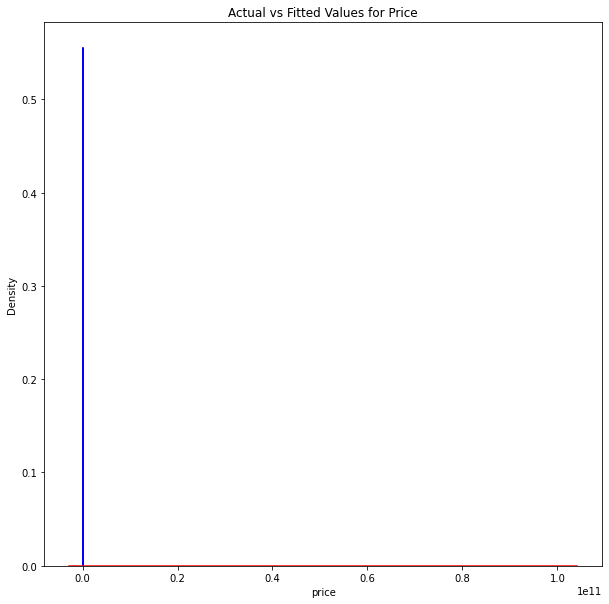

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.distplot(y_test, hist=False, color="b", label="Actual Value")
sns.distplot(y_pred, hist=False, color="r", label="Fitted Values", ax=ax)
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

We see that this linear regression model has very high RMSE and from the graph, we see that it only predicts 0, i.e., it doesn't learn anything.

## PCA

Our dataset has 490 feature columns, which is quite large.

We use Principal component analysis to reduce the dimensions of the dataset. We first fit a PCA model on our train set and then plot the explained_variance_ratio against the number of components to decide the number of components we will keep.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 490)
pca.fit_transform(x_train)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
pc_vs_variance

array([0.11423082, 0.19927779, 0.25722464, 0.30552422, 0.34202418,
       0.37744355, 0.40945398, 0.44019305, 0.4676979 , 0.49072839,
       0.51201982, 0.53315546, 0.55206477, 0.56813408, 0.58344203,
       0.59799152, 0.61152596, 0.62447215, 0.63609876, 0.64746687,
       0.65822032, 0.66888423, 0.67912921, 0.68931286, 0.69903135,
       0.70859344, 0.71790848, 0.72700168, 0.73588761, 0.74432111,
       0.75249803, 0.7604875 , 0.76835244, 0.77607057, 0.78357758,
       0.79079281, 0.79793015, 0.80478311, 0.81156171, 0.8182841 ,
       0.82450258, 0.83053837, 0.83599216, 0.84137586, 0.84645458,
       0.85149824, 0.85630951, 0.86103773, 0.86563064, 0.87015426,
       0.87455154, 0.87871324, 0.8827855 , 0.88670827, 0.89050252,
       0.89419772, 0.89776071, 0.90126254, 0.90466055, 0.90797606,
       0.91120798, 0.9142321 , 0.91722737, 0.92014435, 0.92298307,
       0.92579303, 0.92847807, 0.93112992, 0.93368648, 0.93606666,
       0.93829603, 0.94033514, 0.94227998, 0.94413626, 0.94591

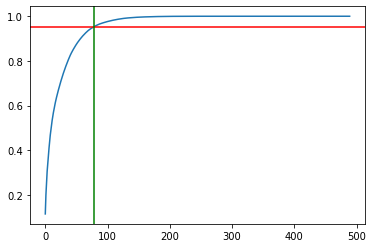

In [ ]:
plt.plot(pc_vs_variance)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=78, color='g', linestyle='-')

We decide to choose the number of components that explain 95% of the variance in the dataset, which in this case is 78. We then fit and transform our pca on the training set using the number of components we decided above.

In [ ]:
pca = PCA(n_components = 78)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

## Linear Regression

In [ ]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)

mse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(mse_test)

0.673862847885759


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



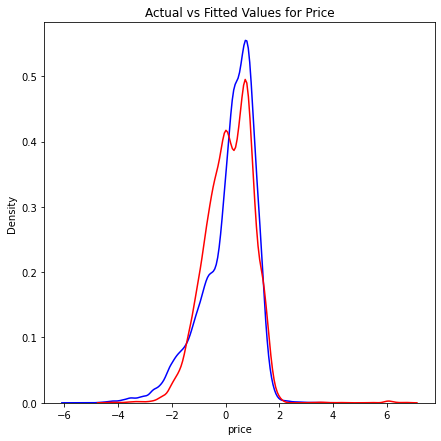

In [ ]:
plt.figure(figsize=(7, 7))
ax = sns.distplot(y_test, hist=False, color="b", label="Actual Values")
sns.distplot(y_pred, hist=False, color="r", label="Fitted Values", ax=ax)
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

We see that the RMSE is much lower now as expected and we see that the distribution of actual price values mirrors the distribution of predicted price values.

We now try Elastic Net Regression, and we perform 5-fold cross-validation to find the best value for l1 ratio.

In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

elastic_net_cv = ElasticNetCV(l1_ratio = l1_ratios, cv = 5, normalize=False)
elastic_net_cv.fit(x_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)

In [ ]:
print(elastic_net_cv.l1_ratio_)
print(elastic_net_cv.alpha_)

0.1
0.0263033068370561


In [ ]:
y_pred = elastic_net_cv.predict(x_test)

mse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(mse_test)

0.6569187927585067


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



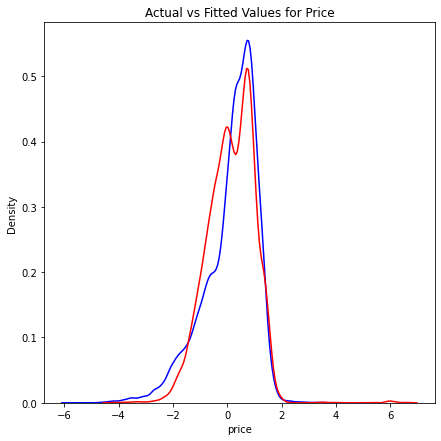

In [ ]:
plt.figure(figsize=(7, 7))
ax = sns.distplot(y_test, hist=False, color="b", label="Actual Values")
sns.distplot(y_pred, hist=False, color="r", label="Fitted Values", ax=ax)
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

We see that the tuned Elastic Net model has slightly better test RMSE.

## Random Forest

We now try Random Forest models to try and get better results.

We start by perform Grid Search with 3-fold Cross-Validation to find the best parameters (not all parameters tried are represented in the code).

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

depths = [10, 15]
n_estimators = [100, 200]

GS_object = GridSearchCV(RandomForestRegressor(), param_grid = {'max_depth' : depths, 'n_estimators' : n_estimators},
                         cv = 3, n_jobs = -1, verbose = True)
GS_object.fit(x_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'n_estimators': [100, 200]},
             verbose=True)

In [ ]:
print(GS_object.best_params_)

{'max_depth': 15, 'n_estimators': 100}


We see that the optimal parameters are random forests with 100 trees each of which has maximum depth of 15. We train a random forest with these parameters.

In [ ]:
rf_model = RandomForestRegressor(n_estimators = 100, max_depth = 15)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

In [ ]:
from sklearn import metrics

print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 0.5261053998773971


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



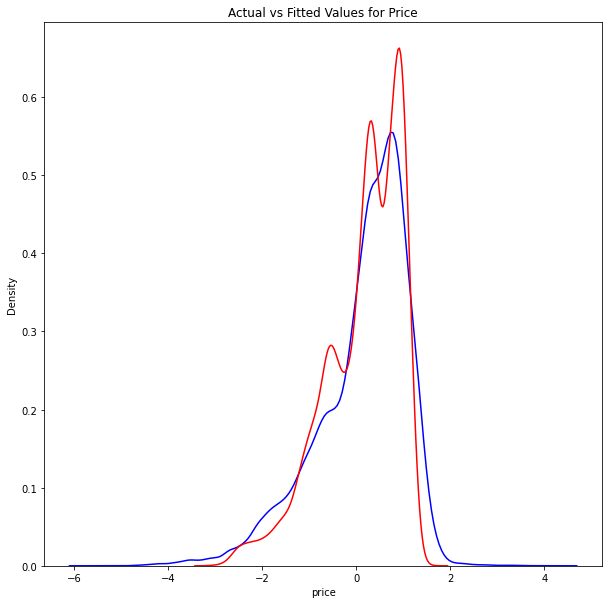

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.distplot(y_test, hist=False, color="b", label="Actual Value")
sns.distplot(y_pred, hist=False, color="r", label="Fitted Values", ax=ax)
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

With this tuned random forest model, we see an improvement over linear models in terms of test RMSE. We also see that the distribution of predicted values has less fat tails.

## XGBoost

Since we saw an improvement with tree-based models, we try XGBoost, which is a specific implementation of gradient boosted decision trees that is designed for speed and performance.

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix, cv, plot_importance

We start by just applying a base XGBoost model with some standard parameter values.

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, colsample_bytree = 0.3, max_depth = 5)
xgb_model.fit(x_train, y_train, early_stopping_rounds = 5, eval_set = [(x_test, y_test)], verbose = False)

[09:30:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = xgb_model.predict(x_test)
mse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(mse_test)

0.2194619332588139


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



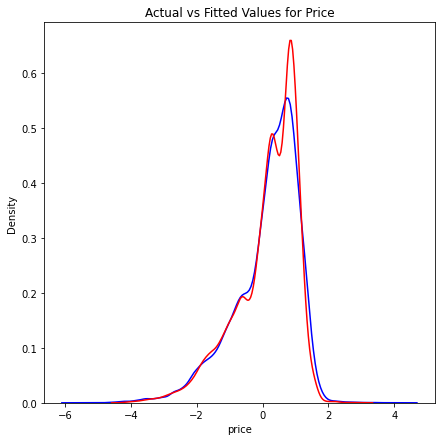

In [ ]:
plt.figure(figsize=(7, 7))
ax = sns.distplot(y_test, hist=False, color="b", label="Actual Values")
sns.distplot(y_pred, hist=False, color="r", label="Fitted Values", ax=ax)
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

We see a significant improvement in test RMSE and the distribution of the predicted price values is very similar to the distribution of actual price values.

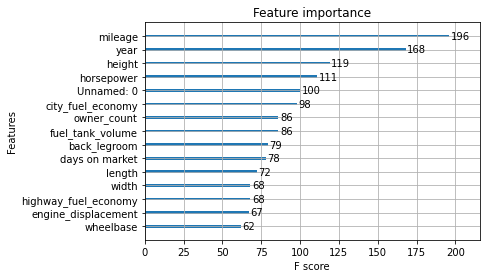

In [ ]:
plot_importance(xgb_model, max_num_features=15)

Using XGBoost, we can also make variable importance plots to try and find which variables have a significant effect on the model. Importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

We see that the features mileage, year, height, and horsepower are significant.

We now perform Grid Search with 3-fold Cross-Validation to try and find the best parameter values for the XGBoost model.

In [ ]:
estimator = XGBRegressor(objective= 'reg:linear', seed=42)

parameters = {'max_depth': [3, 5, 10],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'colsample_bytree': [0.3]}

grid_search = GridSearchCV(estimator=estimator, param_grid=parameters,
    scoring = 'neg_root_mean_squared_error', cv = 3, verbose=True)

grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[09:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 32.9min finished


[10:04:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.3],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10],
  

In [ ]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=1, verbosity=1)

After Grid Seach, we find that the optimal parameters are: learning rate = 0.1, max_depth = 10, n_estimators = 200.

We now train an XGBoost model with these optimal parameters.

In [ ]:
xgb_model_tuned = XGBRegressor(n_estimators=200, learning_rate=0.1, colsample_bytree = 0.3, max_depth = 10)
xgb_model_tuned.fit(x_train, y_train, verbose = True)

[10:11:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = xgb_model_tuned.predict(x_test)
mse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(mse_test)

0.1788383205110842


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



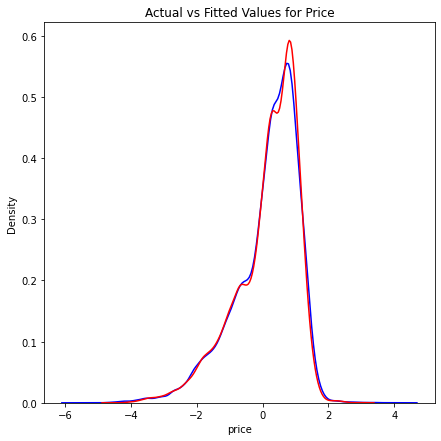

In [ ]:
plt.figure(figsize=(7, 7))
ax = sns.distplot(y_test, hist=False, color="b", label="Actual Values")
sns.distplot(y_pred, hist=False, color="r", label="Fitted Values", ax=ax)
plt.title('Actual vs Fitted Values for Price')
plt.show()
plt.close()

We see that this tuned XGBoost model has the best (lowest) test RMSE so far and the distribution of predicted price values almost perfectly mirrors the distribution of actual price values.

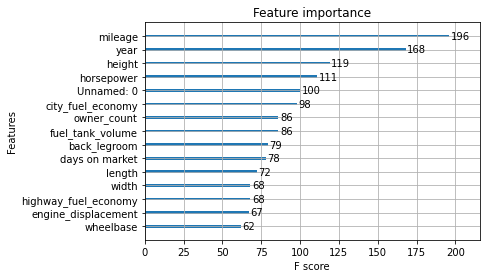

In [ ]:
plot_importance(xgb_model, max_num_features=15)

As above, we see that the features mileage, year, height, and horsepower are significant.

## Neural Network

We attempt to experiment with neural network architectures on 100,000 records of the full dataset with applying PCA, as neural networks perform a certain level of dimensionality reduction in the first layer.

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(device)

1.8.1+cu101
cuda:0


In [ ]:
filepath = '/content/drive/MyDrive/CIS545/used_cars_Final.csv'
cars = pd.read_csv(filepath, index_col='vin', nrows=100000)

In [ ]:
cars.head()

,Unnamed: 0,days on market,price,savings_amount,year,owner_count,fleet,has_accidents,highway_fuel_economy,city_fuel_economy,back_legroom,front_legroom,engine_displacement,horsepower,mileage,fuel_tank_volume,maximum_seating,width,height,wheelbase,length,seller_rating,owner_count_imputed,fleet_imputed,has_accidents_imputed,highway_fuel_economy_imputed,city_fuel_economy_imputed,back_legroom_imputed,front_legroom_imputed,engine_displacement_imputed,horsepower_imputed,mileage_imputed,fuel_tank_volume_imputed,maximum_seating_imputed,width_imputed,height_imputed,wheelbase_imputed,length_imputed,seller_rating_imputed,ground effects package,...,transmission_display_5-Speed Manual Overdrive,transmission_display_6-Speed Automatic,transmission_display_6-Speed Automatic Overdrive,transmission_display_6-Speed Dual Clutch,transmission_display_6-Speed Manual,transmission_display_6-Speed Manual Overdrive,transmission_display_7-Speed Automatic,transmission_display_8-Speed Automatic,transmission_display_8-Speed Automatic Overdrive,transmission_display_8-Speed Dual Clutch,transmission_display_9-Speed Automatic,transmission_display_9-Speed Automatic Overdrive,transmission_display_Automatic,transmission_display_Continuously Variable Transmission,transmission_display_Manual,transmission_display_10-Speed Automatic,transmission_display_7-Speed Dual Clutch,transmission_display_4-Speed CVT,transmission_display_7-Speed Manual,transmission_display_7-Speed Automatic Overdrive,transmission_display_7-Speed CVT,transmission_display_6-Speed CVT,transmission_display_8-Speed Manual,transmission_display_8-Speed CVT,transmission_display_1-Speed Dual Clutch,transmission_display_10-Speed CVT,transmission_display_4-Speed Dual Clutch,transmission_display_5-Speed Dual Clutch,transmission_display_7-Speed Manual Overdrive,wheel_system_4WD,wheel_system_4X2,wheel_system_AWD,wheel_system_FWD,wheel_system_RWD,wheel_system_display_4X2,wheel_system_display_All-Wheel Drive,wheel_system_display_Four-Wheel Drive,wheel_system_display_Front-Wheel Drive,wheel_system_display_None,wheel_system_display_Rear-Wheel Drive
vin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.921144,23.941581,-0.067000,-0.51335,-13.810287,-0.129360,-0.55475,-0.419195,-0.032265,-0.003169,0.006679,-0.007707,-0.010426,0.061553,18.600474,0.012835,-0.064689,0.065792,0.032786,0.012699,-0.004357,1.436765,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,4.330213,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870317,-1.366971,2.466289,1.932629,-0.51335,-11.891662,-0.297735,-0.55475,-0.419195,-0.006567,0.028938,0.061094,-0.002447,-0.037426,0.065433,-0.335747,-0.006724,-0.067567,0.079702,0.056501,0.024829,0.000687,0.710643,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,-0.230936,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870719,0.674975,0.107365,1.587727,-0.51335,-11.891662,-0.139066,-0.55475,-0.419195,-0.020552,0.007428,0.018727,-0.007741,-0.011149,0.037371,-0.075465,0.006935,-0.061319,0.035754,0.037503,0.015541,-0.001581,0.354701,1.010291,-0.929041,-0.929041,2.263899,2.263899,3.412164,4.210379,4.282711,4.282711,-0.230936,4.422341,4.437994,4.438815,4.438863,4.439104,4.439104,-0.103432,-0.011091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
00000000012870842,-1.670468,1.205172,2.392290,-0.51335,-11.891662,-0.136389,-0.55475,-0.419195,-0.029342,-0.000342,0.010976,-0.007641,-0.011063,0.056441,16.071

In [ ]:
label = torch.Tensor(cars['price'].values.astype(float))
features = torch.Tensor(cars.drop(['price'], axis = 1).values.astype(float))

We create a 80-20 train-test split.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [ ]:
num_features = 490
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128
hidden_dim4 = 32

neural_net = nn.Sequential(
    nn.Linear(num_features, hidden_dim1),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(hidden_dim1, hidden_dim2),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(hidden_dim2, hidden_dim3),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(hidden_dim3, hidden_dim4),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(hidden_dim4, 1),
)

In [ ]:
input_dim = 490
summary(neural_net.to(device), (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         251,392
              ReLU-2               [-1, 1, 512]               0
           Dropout-3               [-1, 1, 512]               0
            Linear-4               [-1, 1, 256]         131,328
              ReLU-5               [-1, 1, 256]               0
           Dropout-6               [-1, 1, 256]               0
            Linear-7               [-1, 1, 128]          32,896
              ReLU-8               [-1, 1, 128]               0
           Dropout-9               [-1, 1, 128]               0
           Linear-10                [-1, 1, 32]           4,128
             ReLU-11                [-1, 1, 32]               0
          Dropout-12                [-1, 1, 32]               0
           Linear-13                 [-1, 1, 1]              33
Total params: 419,777
Trainable params:

We create a network architecture with 4 hidden layers and Dropout (a regularisation method) incorporated to help reduce overfitting.

We use MSE as our Loss Criterion and we use the Adam optimiser.

In [ ]:
criterion = nn.MSELoss()
optim = torch.optim.Adam(neural_net.parameters(), lr=0.001)

Training Method:

In [ ]:
loss_list = []

def train_model(model, optimizer, criterion, epochs=20):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    model.train()
    model.to(device)
    
    for epoch in range(epochs):
      running_loss = 0.0
      correct = 0
      total = 0
      for data, labels in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        labels = labels.to(device)
        predictions = model(data)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

      training_loss = running_loss/len(train_dataset)
      loss_list.append(training_loss)
      print(f'Epoch {epoch + 1}: loss = {training_loss}')

    final_training_loss = training_loss
    return final_training_loss

In [ ]:
training_loss = train_model(neural_net, optim, criterion, 10)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 1: loss = 0.02973238359950483
Epoch 2: loss = 0.029709014742821456
Epoch 3: loss = 0.02970517879575491
Epoch 4: loss = 0.029706932179257274
Epoch 5: loss = 0.029707085050269963
Epoch 6: loss = 0.029709597762674095
Epoch 7: loss = 0.02970367426201701
Epoch 8: loss = 0.02970771886371076
Epoch 9: loss = 0.029707967952266337
Epoch 10: loss = 0.029704324954003096


Text(0, 0.5, 'Training Loss')

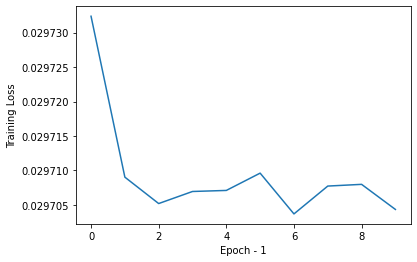

In [ ]:
plt.figure()
plt.plot(loss_list)
plt.xlabel('Epoch - 1')
plt.ylabel('Training Loss')

Test Method:

In [ ]:
y_preds = []

def test_model(model, criterion):
    model.eval()
    torch.no_grad()

    running_loss = 0.0
    correct = 0
    total = 0
    for data, labels in test_loader:
      data = data.to(device)
      labels = labels.to(device)
      predictions = model(data)
      y_preds.append(predictions)
      loss = criterion(predictions, labels)
      
      running_loss += loss.item()

    testing_loss = running_loss/len(test_dataset)
    return testing_loss

In [ ]:
testing_loss = test_model(neural_net, criterion)
print(testing_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



0.029636730453372003


We see that the test RMSE is ~ 0.17, which is comparable to the tuned XGBoost model.

Thus, based on our initial experiments with limited data, we find that the neural network and the tree-based models (random forests and XGBoost) perform the best.

## Using Spark

In order to build models on the full dataset, we use Spark to help with computational problems.

In [42]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user

!apt update
!apt install gcc python-dev libkrb5-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 77 not upgraded.
--2021-05-06 23:44:17--  https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving www-us.apache.org (www-us.apache.org)... 207.244.88.140
Connecting to www-us.apache.org (www-us.apache.org)|207.244.88.140|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz [following]
--2021-05-06 23:44:18--  https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.209.10, 135.181.214.104, ...
Connecting to downloads.apach

In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('ml-project').getOrCreate()

%load_ext sparkmagic.magics

The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics


In [44]:
import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [46]:
train_sdf = spark.read.format("csv").option("header", "true").load("/content/drive/MyDrive/CIS545/used_cars_Final.csv", inferSchema = True)

train_sdf.show()

+-----------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+---------------------+----------------------------+-------------------------+--------------------+---------------------+---------------------------+------------------+--------------------+------------------------+-----------------------+-----------------+-----------------+------------------+-----------------+---------------------+----------------------+--------------------+--------------------+----------------+--------------------+--------------------+---------+----------------

In [47]:
train_sdf.printSchema()

root
 |-- vin: string (nullable = true)
 |-- Unnamed: 0: double (nullable = true)
 |-- days on market: double (nullable = true)
 |-- price: double (nullable = true)
 |-- savings_amount: double (nullable = true)
 |-- year: double (nullable = true)
 |-- owner_count: double (nullable = true)
 |-- fleet: double (nullable = true)
 |-- has_accidents: double (nullable = true)
 |-- highway_fuel_economy: double (nullable = true)
 |-- city_fuel_economy: double (nullable = true)
 |-- back_legroom: double (nullable = true)
 |-- front_legroom: double (nullable = true)
 |-- engine_displacement: double (nullable = true)
 |-- horsepower: double (nullable = true)
 |-- mileage: double (nullable = true)
 |-- fuel_tank_volume: double (nullable = true)
 |-- maximum_seating: double (nullable = true)
 |-- width: double (nullable = true)
 |-- height: double (nullable = true)
 |-- wheelbase: double (nullable = true)
 |-- length: double (nullable = true)
 |-- seller_rating: double (nullable = true)
 |-- owner_c

In [48]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [49]:
# Your code goes here
all_columns = ['Unnamed: 0', 'days on market', 'price', 'savings_amount', 'year', 'owner_count', 'fleet', 'has_accidents',
               'highway_fuel_economy', 'city_fuel_economy', 'back_legroom', 'front_legroom', 'engine_displacement',
               'horsepower', 'mileage', 'fuel_tank_volume', 'maximum_seating', 'width', 'height', 'wheelbase', 'length',
               'seller_rating', 'owner_count_imputed', 'fleet_imputed', 'has_accidents_imputed', 'highway_fuel_economy_imputed',
               'city_fuel_economy_imputed', 'back_legroom_imputed', 'front_legroom_imputed', 'engine_displacement_imputed',
               'horsepower_imputed', 'mileage_imputed', 'fuel_tank_volume_imputed', 'maximum_seating_imputed', 'width_imputed',
               'height_imputed', 'wheelbase_imputed', 'length_imputed', 'seller_rating_imputed', 'ground effects package',
               'sl package', 'acoustical package', 'sr grade package', 'limited package', 'upgrade package', 'f package',
               'lariat package', 's line sport package', 'suspension package', 'adaptive suspension', 'audio package', 'backup camera',
               'storage package', 'luxury package', 'le package', 'multimedia package', 'winter package', 'security package',
               'heat package', 'xle package', 'parking sensors', 'driver assistance package', 'power package', 'wood upgrade package',
               'a mid equipment group', 'safety package', 'premium smooth ride suspension package', 'cold weather package',
               'sport chrono package', 'sxt package', 'heated seats', 'leather seats', 'm sport package', 'performance handling package',
               'standard suspension package', 'carbon ceramic brakes', 'ls package', 'tow package', 'bluetooth', 'ambient light package',
               'dual rear wheels', 'convenience plus package', 'luxury ride suspension package', 'third row seating', 
               'quick order package', 'preferred equipment package', 'premium sound package', 'sr package', 'driver confidence package',
               'grand tour package', 'sunroofmoonroof', 'courtesy lights illum package', 'alloy wheels', 'tour package', 
               'premium audio package', 'th wheel', 'adaptive cruise control', 's line package', 'power mirror package', 
               'premium wheels', 'levant package', 'lt package', 'memory package', 'p premium package', 'trailer package',
               'journey package', 'rs package', 'extra value package', 'ultimate package', 'smoker package', 'amg sport package', 
               'carplay', 'utility package', 'premium plus package', 'multi zone climate control', 'off road package', 
               'se package', 'heavy duty trailer package', 'graphics package', 'none', 'sle package', 'comfort package',
               'popular equipment package', 'luxury sound insulation package', 'bose high end sound package', 'remote vehicle starter prep package', 
               'customer preferred package', 'z  package', 'license plate front mount package', 'android auto', 'steel wheels', 
               'premium package', 'blind spot monitoring', 'special edition package', 'king ranch package', 'trim package', 
               'quiet package', 'rear climate package', 'trd package', 'wood trim package', 'value package', 'convenience package', 
               'handicap accessible', 'remote start', 'performance package', 'executive package', 'cargo package', 'technology package', 
               'z package', 'light package', 'premium  package', 'xlt package', 'preferred premium accessory package', 'ultra luxury package',
               'dvd entertainment system', 'p package', 'chrome wheels', 'preferred package', 'preferred accessory package',
               'appearance package', 'sound package', 'sport activity package', 'autoride suspension package', 'a luxury equipment group',
               'elite package', 'sport package', 'allwheel steering', 'bi xenon headlamp package', 'navigation system', 'skid plate package',
               'solid smooth ride suspension package', 'slt package', 'appearance and protection package', 'body_type_Convertible',
               'body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 
               'body_type_Sedan', 'body_type_Van', 'body_type_Wagon', 'State_0', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 
               'State_CO', 'State_CT', 'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 
               'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 
               'State_MT', 'State_NC', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 
               'State_OR', 'State_PA', 'State_PR', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_VA', 'State_VT', 
               'State_WA', 'State_WI', 'State_WV', 'State_UT', 'State_WY', 'State_AK', 'State_ND', 'engine_type_I4', 'engine_type_I4 Compressed Natural Gas', 
               'engine_type_I4 Flex Fuel Vehicle', 'engine_type_I4 Hybrid', 'engine_type_I6', 'engine_type_I6 Diesel', 'engine_type_V10',
               'engine_type_V6', 'engine_type_V6 Diesel', 'engine_type_V6 Flex Fuel Vehicle', 'engine_type_V6 Hybrid', 'engine_type_V8', 
               'engine_type_V8 Diesel', 'engine_type_V8 Flex Fuel Vehicle', 'engine_type_I3', 'engine_type_I5 Biodiesel', 
               'engine_type_V6 Biodiesel', 'engine_type_V8 Biodiesel', 'engine_type_I4 Diesel', 'engine_type_I5', 'engine_type_V8 Compressed Natural Gas', 
               'engine_type_V8 Hybrid', 'engine_type_H4', 'engine_type_H6', 'engine_type_H4 Hybrid', 'engine_type_R2', 'engine_type_I2', 
               'engine_type_I5 Diesel', 'engine_type_I6 Hybrid', 'engine_type_V10 Diesel', 'engine_type_V12', 'engine_type_W12', 
               'engine_type_W12 Flex Fuel Vehicle', 'engine_type_W16', 'engine_type_W8', 'frame_damaged_False', 'frame_damaged_True', 
               'franchise_dealer_False', 'franchise_dealer_True', 'franchise_make_Acura', 'franchise_make_Alfa Romeo', 'franchise_make_Aston Martin', 
               'franchise_make_Audi', 'franchise_make_BMW', 'franchise_make_Bentley', 'franchise_make_Buick', 'franchise_make_Cadillac', 'franchise_make_Chevrolet', 
               'franchise_make_Chrysler', 'franchise_make_Dodge', 'franchise_make_FIAT', 'franchise_make_Ferrari', 'franchise_make_Ford', 'franchise_make_GMC', 
               'franchise_make_Genesis', 'franchise_make_Honda', 'franchise_make_Hyundai', 'franchise_make_INFINITI', 'franchise_make_Jaguar', 'franchise_make_Jeep', 
               'franchise_make_Kia', 'franchise_make_Lamborghini', 'franchise_make_Land Rover', 'franchise_make_Lexus', 'franchise_make_Lincoln', 
               'franchise_make_Lotus', 'franchise_make_MINI', 'franchise_make_Maserati', 'franchise_make_Mazda', 'franchise_make_McLaren', 'franchise_make_Mercedes-Benz', 
               'franchise_make_Mitsubishi', 'franchise_make_Nissan', 'franchise_make_Porsche', 'franchise_make_Rolls-Royce', 'franchise_make_Rover', 'franchise_make_SRT', 
               'franchise_make_Scion', 'franchise_make_Shelby', 'franchise_make_Subaru', 'franchise_make_Toyota', 'franchise_make_Unknown', 'franchise_make_Volkswagen', 
               'franchise_make_Volvo', 'franchise_make_RAM', 'franchise_make_smart', 'franchise_make_Pagani', 'fuel_type_Compressed Natural Gas', 'fuel_type_Diesel', 
               'fuel_type_Flex Fuel Vehicle', 'fuel_type_Gasoline', 'fuel_type_Hybrid', 'fuel_type_Biodiesel', 'fuel_type_Electric', 'isCab_0', 
               'isCab_False', 'isCab_True', 'is_cpo_0', 'is_cpo_True', 'is_new_False', 'is_new_True', 'listing_color_BLACK', 'listing_color_BLUE', 
               'listing_color_BROWN', 'listing_color_GOLD', 'listing_color_GRAY', 'listing_color_GREEN', 'listing_color_ORANGE', 'listing_color_PINK', 
               'listing_color_PURPLE', 'listing_color_RED', 'listing_color_SILVER', 'listing_color_TEAL', 'listing_color_UNKNOWN', 'listing_color_WHITE', 
               'listing_color_YELLOW', 'make_name_AM General', 'make_name_Acura', 'make_name_Alfa Romeo', 'make_name_Austin-Healey', 'make_name_Buick', 
               'make_name_Cadillac', 'make_name_Chevrolet', 'make_name_Chrysler', 'make_name_Dodge', 'make_name_FIAT', 'make_name_Ferrari', 'make_name_Ford',
               'make_name_GMC', 'make_name_Honda', 'make_name_Hummer', 'make_name_Hyundai', 'make_name_Jeep', 'make_name_Lincoln', 'make_name_MG', 'make_name_Maserati', 
               'make_name_Mercedes-Benz', 'make_name_Mercury', 'make_name_Mitsubishi', 'make_name_Nissan', 'make_name_Oldsmobile', 'make_name_Opel', 'make_name_Plymouth', 
               'make_name_Pontiac', 'make_name_Porsche', 'make_name_SRT', 'make_name_Shelby', 'make_name_Studebaker', 'make_name_Subaru', 'make_name_Sunbeam', 
               'make_name_Toyota', 'make_name_Triumph', 'make_name_Volkswagen', 'make_name_Volvo', 'make_name_Willys', 'make_name_RAM', 'make_name_Isuzu', 
               'make_name_Saturn', 'make_name_BMW', 'make_name_Geo', 'make_name_Hudson', 'make_name_Land Rover', 'make_name_Mazda', 'make_name_Lexus', 
               'make_name_Suzuki', 'make_name_Kia', 'make_name_Saab', 'make_name_Bentley', 'make_name_Eagle', 'make_name_INFINITI', 'make_name_Karma', 
               'make_name_Scion', 'make_name_VPG', 'make_name_AMC', 'make_name_Datsun', 'make_name_Jaguar', 'make_name_Kaiser', 'make_name_Lotus', 
               'make_name_Rolls-Royce', 'make_name_Tesla', 'make_name_Daewoo', 'make_name_Genesis', 'make_name_Aston Martin', 'make_name_Audi', 
               'make_name_Bugatti', 'make_name_Edsel', 'make_name_Fisker', 'make_name_Freightliner', 'make_name_Lamborghini', 'make_name_MINI', 
               'make_name_Maybach', 'make_name_McLaren', 'make_name_Pagani', 'make_name_Pininfarina', 'make_name_Spyker', 'make_name_smart', 'salvage_False', 
               'salvage_True', 'theft_title_0', 'theft_title_False', 'theft_title_True', 'transmission_A', 'transmission_CVT', 
               'transmission_Dual Clutch', 'transmission_M', 'transmission_display_1-Speed Automatic', 'transmission_display_1-Speed CVT', 
               'transmission_display_2-Speed Automatic', 'transmission_display_3-Speed Automatic', 'transmission_display_3-Speed Manual', 
               'transmission_display_4-Speed Automatic', 'transmission_display_4-Speed Automatic Overdrive', 'transmission_display_4-Speed Manual', 
               'transmission_display_4-Speed Manual Overdrive', 'transmission_display_5-Speed Automatic', 'transmission_display_5-Speed Automatic Overdrive', 
               'transmission_display_5-Speed Manual', 'transmission_display_5-Speed Manual Overdrive', 'transmission_display_6-Speed Automatic', 
               'transmission_display_6-Speed Automatic Overdrive', 'transmission_display_6-Speed Dual Clutch', 'transmission_display_6-Speed Manual', 
               'transmission_display_6-Speed Manual Overdrive', 'transmission_display_7-Speed Automatic', 'transmission_display_8-Speed Automatic',
               'transmission_display_8-Speed Automatic Overdrive', 'transmission_display_8-Speed Dual Clutch', 'transmission_display_9-Speed Automatic',
               'transmission_display_9-Speed Automatic Overdrive', 'transmission_display_Automatic', 'transmission_display_Continuously Variable Transmission', 
               'transmission_display_Manual', 'transmission_display_10-Speed Automatic', 'transmission_display_7-Speed Dual Clutch', 
               'transmission_display_4-Speed CVT', 'transmission_display_7-Speed Manual', 'transmission_display_7-Speed Automatic Overdrive', 
               'transmission_display_7-Speed CVT', 'transmission_display_6-Speed CVT', 'transmission_display_8-Speed Manual',
               'transmission_display_8-Speed CVT', 'transmission_display_1-Speed Dual Clutch', 'transmission_display_10-Speed CVT', 
               'transmission_display_4-Speed Dual Clutch', 'transmission_display_5-Speed Dual Clutch', 'transmission_display_7-Speed Manual Overdrive', 
               'wheel_system_4WD', 'wheel_system_4X2', 'wheel_system_AWD', 'wheel_system_FWD', 'wheel_system_RWD', 'wheel_system_display_4X2', 
               'wheel_system_display_All-Wheel Drive', 'wheel_system_display_Four-Wheel Drive', 'wheel_system_display_Front-Wheel Drive', 
               'wheel_system_display_None', 'wheel_system_display_Rear-Wheel Drive',
               ]

drop_columns = ['Unnamed: 0', 'price']

columns_to_use = [i for i in all_columns if i not in drop_columns]

assembler = VectorAssembler(inputCols = columns_to_use, outputCol = "features")

In [50]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [assembler])
train_sdf = train_sdf.drop('video_id')
pipe_model = pipeline.fit(train_sdf)
modified_data_sdf = pipe_model.transform(train_sdf)

We create a 80-20 Train-Test split of our data.

In [51]:
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2], seed = 42)

We perform PCA on the data to reduce its dimensionality. We use the optimal value for PCA that we got from applying PCA previously.

In [53]:
from pyspark.ml.feature import PCA

pca = PCA(k = 78, inputCol = 'features', outputCol = 'pca')
pca_model = pca.fit(train_sdf)
train_pca = pca_model.transform(train_sdf)

In [54]:
from pyspark.ml.regression import LinearRegression

linear_pca = LinearRegression(featuresCol = 'pca', labelCol = 'price')
linear_pca_model = linear_pca.fit(train_pca)

trainingSummary = linear_pca_model.summary

print("Training RMSE: %f" % trainingSummary.rootMeanSquaredError)

Training RMSE: 0.497151


In [55]:
from pyspark.ml.evaluation import RegressionEvaluator

test_pca = pca_model.transform(test_sdf)
predictions = linear_pca_model.transform(test_pca)
test_evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'price', metricName = 'rmse')
test_rmse_pca = test_evaluator.evaluate(predictions)
print("Testing RMSE: %f" % test_rmse_pca)

Testing RMSE: 0.494925


We see that for the Linear Regression model, we have:

Training RMSE: 0.497151

Test RMSE: 0.494925

We now try LASSO, Ridge, and more generally Elastic Net Regression models.

In [57]:
l1 = LinearRegression(featuresCol = 'features', labelCol = 'price', regParam = 0.1, elasticNetParam = 1)
l1_model = l1.fit(train_pca)
trainingSummary_l1 = l1_model.summary
print("Training RMSE: %f" % trainingSummary_l1.rootMeanSquaredError)

l1_predictions = l1_model.transform(test_pca)
l1_evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'price', metricName = 'rmse')
test_rmse_l1 = l1_evaluator.evaluate(l1_predictions)
print("Testing RMSE: %f" % test_rmse_l1)

Training RMSE: 0.482449
Testing RMSE: 0.484754


In [59]:
l2 = LinearRegression(featuresCol = 'features', labelCol = 'price', regParam = 0.1, elasticNetParam = 0)
l2_model = l2.fit(train_pca)
trainingSummary_l2 = l2_model.summary
print("Training RMSE: %f" % trainingSummary_l2.rootMeanSquaredError)

l2_predictions = l2_model.transform(test_pca)
l2_evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'price', metricName = 'rmse')
test_rmse_l2 = l2_evaluator.evaluate(l2_predictions)
print("Testing RMSE: %f" % test_rmse_l2)

Training RMSE: 0.338075
Testing RMSE: 0.343192


In [60]:
elastic_net = LinearRegression(featuresCol = 'features', labelCol = 'price', regParam = 0.1, elasticNetParam = 0.8)
elastic_net_model = elastic_net.fit(train_pca)
trainingSummary_elastic = elastic_net_model.summary
print("Training RMSE: %f" % trainingSummary_elastic.rootMeanSquaredError)

elastic_net_predictions = elastic_net_model.transform(test_pca)
elastic_net_evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'price', metricName = 'rmse')
test_rmse_elastic = elastic_net_evaluator.evaluate(elastic_net_predictions)
print("Testing RMSE: %f" % test_rmse_elastic)

Training RMSE: 0.464823
Testing RMSE: 0.467080


We see that all the 3 models we've tried above have better performance than the simple linear model with respect to both training and testing RMSE.

We find a significant improvement in performance with elasticNetParam = 0, i.e., with the Ridge Regression model.

We now try Random Forests, since we saw improved performance in previous sections when using tree-based models.

In [61]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

randomforest = RandomForestRegressor(featuresCol = 'features', labelCol = 'price')
rf_model = randomforest.fit(train_pca)
rf_training_pred = rf_model.transform(train_pca)
rf_evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'price', metricName = 'rmse')
train_rmse_rf = rf_evaluator.evaluate(rf_training_pred)
print("Training RMSE: %f" % train_rmse_rf)

predictions = rf_model.transform(test_pca)
test_rmse_rf = rf_evaluator.evaluate(predictions)
print("Testing RMSE: %f" % test_rmse_rf)

Training RMSE: 0.400596
Testing RMSE: 0.397652


We see an improvement here over the linear regression models but we still see better performance with the Ridge regression model.

# Challenges/Obstacles Faced

- The most significant challenge by far was the size of the dataset. We were forced to only use a third of the full dataset (1 million rows) due to computational issues and with the initial modeling approaches we only used 100,000 rows. Even using Spark, training simple models took a long time and so we did not attempt more complex modeling approaches.

- There were quite a few missing values in the dataset, and we had to find an appropriate method to impute those values.

- By using one-hot encoding for quite a few of the columns, we ended up with a large number of features and so we had to use PCA to reduce dimensionality.

# Potential Next Steps/Future Direction

- The most important next step would be to train our models on the full dataset and then compare results.

- We could try to use a greater variety of potential feature values in our Grid Search efforts for various models to find the optimal parameter values.

- We could try to use more complex modeling approaches, for example a deeper neural network architecture for the full dataset, or a larger numer of trees and depth for random forests and XGBoost.